# CS109A - Final Project

# Canvas Group - Final Project # 150

# Group Members - Akhil Srivastava, Han Truong, Yuying Qian

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

verbose = False

# Used to parse 'Date Time' column values as pandas DatetimeIndex
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

# Setup Data Pipeline

### Functions to Read and Scale the Data

In [3]:
# Reads Data Downloaded from Yahoo!
def read_yahoo_data(file_name):
    # Read the file and parse 'Date' column values as pandas DatetimeIndex
    df = pd.read_csv(file_name, parse_dates=['Date'], date_parser=dateparse)

    # Set 'Date' column as index
    df.set_index('Date', inplace=True)

    # Drop 'Adj Close' and 'Volume' columns as they are not needed
    df = df.drop(['Adj Close', 'Volume'], 1) 
    
    return df

# Reads Data Downloaded from Bloomberg
def read_bloomberg_data(file_name):
    # Read the file and parse 'DATE' column values as pandas DatetimeIndex
    df = pd.read_csv(file_name, parse_dates=['DATE'], date_parser=dateparse)
    
    df.columns = ['Date','Open','High','Low','Close','Volume']

    # Set 'Date' column as index
    df.set_index('Date', inplace=True)

    # Drop 'Volume' columns as they are not needed
    df = df.drop(['Volume'], 1)
    
    return df

def perform_scaling(df):    
     # Create a new dataframe for the scaled values
    df_scaled = df.copy()

    # Dictionary to save the MinMaxScaler scalar objects used for the price transformation
    scalers = {}

    # Scale the data
    for column in df_scaled.columns:
        # Create a new MinMaxScaler scalar object 
        scaler = MinMaxScaler(feature_range = (0, 1))

        # Apply the transformaion on current column
        df_scaled[column] = scaler.fit_transform(df_scaled[[column]])

        # Save the MinMaxScaler object used for price for reverse transformation later
        scalers[column] = scaler
            
    return df_scaled, scalers

### Specify Security Names, Data Dir Name, File Names and Data Reader Function

In [4]:
yahoo_security_list = ['Apple Stock', 'Amazon Stock', 'Microsoft Stock', 'S&P 500 Index', 'Nasdaq 100 Index']
yahoo_data_dir = './yahoo_full_data/'
yahoo_file_list = ['AAPL.csv', 'AMZN.csv', 'MSFT.csv', '^GSPC.csv', '^IXIC.csv']

#bloomberg_security_list = ['Apple Stock', 'Microsoft Stock', 'S&P 500 Index', 'Nasdaq 100 Index']
bloomberg_security_list = ['Apple Stock', 'Microsoft Stock']
bloomberg_data_dir = './data/'
#bloomberg_file_list = ['Apple.csv', 'Microsoft.csv', 'SP500.csv', 'NASDAQ100.csv']
bloomberg_file_list = ['Apple.csv', 'Microsoft.csv']

security_list = bloomberg_security_list
data_dir = bloomberg_data_dir
file_list = bloomberg_file_list
data_reader = read_bloomberg_data

### Read and Scale the Data

In [5]:
# Dictionaries to store security price, price diff, price diff of log returns, scaled price and scalers
dfs_price = {}
dfs_price_diff = {}
dfs_price_diff_log_return = {}
dfs_price_scaled = {}
scalers = {}

# Display Summary Statistics, Price Charts and ACF & PACF Plots for Price, Price Difference and Log Returns
for i in range(len(security_list)):
    print("Processing", security_list[i], "...")

    df = data_reader(data_dir + file_list[i]).dropna()['2010-01-04':]
    df_diff = df.diff().dropna()
    df_diff_log_returns = np.log(df).diff().dropna()
            
    dfs_price[security_list[i]] = df
    dfs_price_diff[security_list[i]] = df_diff
    dfs_price_diff_log_return[security_list[i]] = df_diff_log_returns
    dfs_price_scaled[security_list[i]], scalers[security_list[i]] = perform_scaling(df)

Processing Apple Stock ...
Processing Microsoft Stock ...


# Exploratory Data Analysis

### Functions to Display Summary Statistics, Price Charts and ACF & PACF Charts

In [6]:
# Displays Summary Statistics and Top and Bottom Rows
def describe_and_peek(df, security_name):
    print("\nNumber of observations:", len(df.index), "\n")    
    print(security_name, "- Summary Statistics\n\n", df.describe(), "\n")
    print(security_name, "- Top Rows\n\n", df.head(3), "\n")
    print(security_name, "- Bottom Rows\n\n", df.tail(3), "\n")

# Displays Price Charts
def display_price_charts(df, security_name, price_type, unit):    
    title =  price_type + security_name + " Daily Price" +  " (in " + unit + ")"
    columns = df.columns.values
    nrows = len(df.columns)//2
    
    fig, ax = plt.subplots(nrows=nrows, ncols=2, sharex=False, figsize=(18, 8*nrows))
    fig.suptitle(title, y=0.95, size=18)
    plt.subplots_adjust(wspace = 0.13, hspace = 0.3)

    for i in range(len(columns)):
        row = i//2
        column = i%2
        
        ax[row, column].plot(df.index, df[columns[i]], "-o", ms='1', color=np.random.rand(3,))
        ax[row, column].set_title(price_type + columns[i] + " Price", fontsize=18)
        ax[row, column].set_xlabel("Date", fontsize=15)
        ax[row, column].grid(True);
        
    plt.show()

# Displays ACF and PACF Charts
def plot_acf_pacf(df, security_name, price_type):    
    h_max = 60 
    title =  "ACF and PACF of " + price_type + security_name + " Daily Price"
    columns = df.columns.values

    fig, ax = plt.subplots(nrows=len(columns), ncols=2, sharex=False, figsize=(18, 8*len(columns)))
    ax = ax.reshape(-1, 2)
    fig.suptitle(title, y=1, size=18)
    plt.subplots_adjust(wspace = 0.13, hspace = 0.3)
    
    for i in range(len(columns)):
        plot_acf(df[columns[i]], ax=ax[i, 0], lags=h_max, color='crimson')
        ax[i, 0].set_xlabel("lag", fontsize=15)
        ax[i, 0].set_ylabel("ACF", fontsize=15)
        ax[i, 0].set_title("ACF - " + price_type + columns[i] + " Price", fontsize=15)
        ax[i, 0].grid(True)

        plot_pacf(df[columns[i]], ax=ax[i, 1], lags=h_max, color='lightseagreen')
        ax[i, 1].set_xlabel("lag", fontsize=15)
        ax[i, 1].set_ylabel("PACF", fontsize=15)
        ax[i, 1].set_title("PACF - " + price_type + columns[i] + " Price", fontsize=15)
        ax[i, 1].grid(True)

    plt.show()

# Displays Price, ACF and PACF Charts
def display_price_acf_pacf(df, security_name, price_type, unit):
    title =  price_type + security_name + " Daily Price" +  " (in " + unit + ")"
    columns = df.columns.values
    nrows = len(df.columns)
    h_max = 30

    fig, ax = plt.subplots(nrows=nrows, ncols=3, sharex=False, figsize=(18, 5*nrows))
    ax = ax.reshape(-1, 3)
    fig.suptitle(title, y=1.05, size=18)
    plt.subplots_adjust(wspace = 0.12, hspace = 0.3)

    for i in range(nrows):        
        ax[i, 0].plot(df[columns[i]], "-o", ms='1', color=np.random.rand(3,))
        ax[i, 0].set_title(price_type + columns[i] + " Price", fontsize=14)
        ax[i, 0].set_xlabel("Date", fontsize=12)
        ax[i, 0].grid(True);

        plot_acf(df[columns[i]], ax=ax[i, 1], lags=h_max, color='crimson')
        ax[i, 1].set_xlabel("lag", fontsize=12)      
        ax[i, 1].set_title("ACF - " + price_type + columns[i] + " Price", fontsize=14)
        ax[i, 1].grid(True)

        plot_pacf(df[columns[i]], ax=ax[i, 2], lags=h_max, color='lightseagreen')
        ax[i, 2].set_xlabel("lag", fontsize=12)  
        ax[i, 2].set_title("PACF - " + price_type + columns[i] + " Price", fontsize=14)
        ax[i, 2].grid(True)

    plt.show()

### Display Summary Statistics, Price Charts and ACF & PACF Charts


********************************* Processing Apple Stock *********************************

Number of observations: 2737 

Apple Stock - Summary Statistics

               Open         High          Low        Close
count  2737.000000  2737.000000  2737.000000  2737.000000
mean     32.708361    33.045324    32.368705    32.720336
std      22.656615    22.970535    22.327845    22.664399
min       6.870000     7.000000     6.795000     6.859000
25%      17.344000    17.523000    17.169000    17.365000
50%      26.800000    27.000000    26.545000    26.778000
75%      42.580000    42.948000    42.250000    42.545000
max     137.590000   137.980000   130.530000   134.180000 

Apple Stock - Top Rows

              Open   High    Low  Close
Date                                  
2010-01-04  7.623  7.661  7.585  7.643
2010-01-05  7.664  7.700  7.616  7.656
2010-01-06  7.656  7.687  7.527  7.535 

Apple Stock - Bottom Rows

               Open     High     Low   Close
Date                   

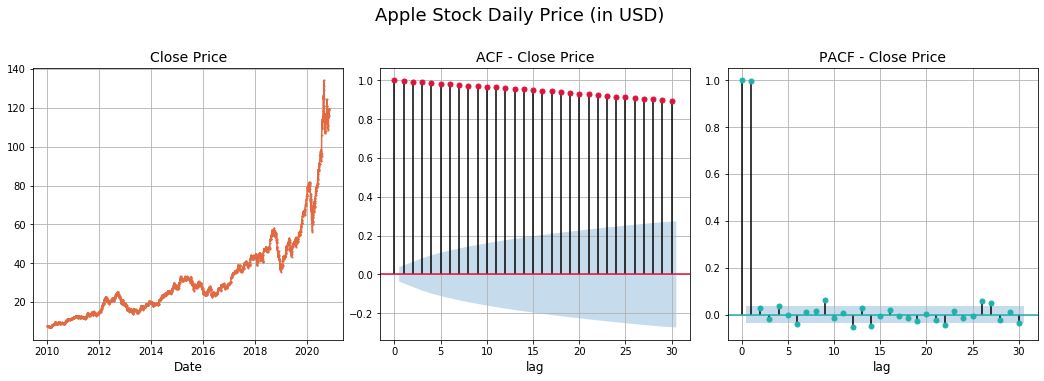

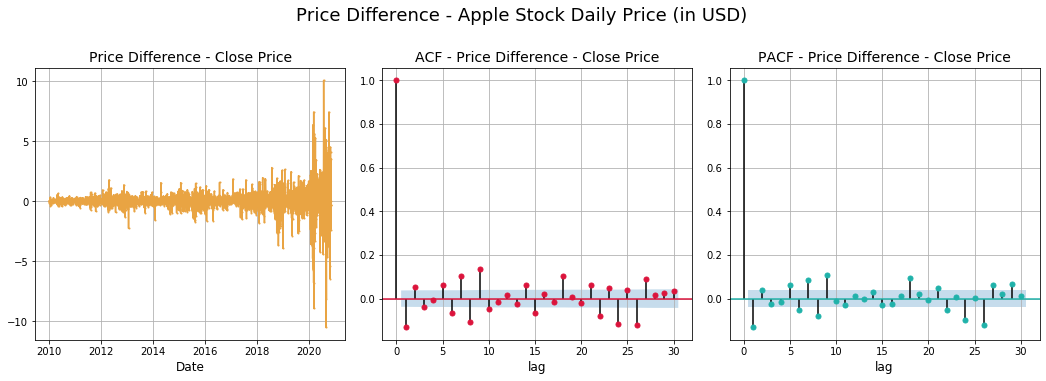

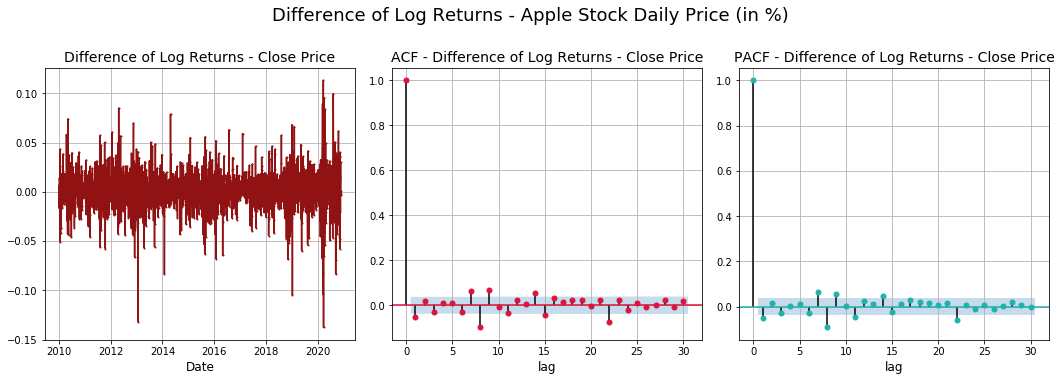


********************************* Processing Microsoft Stock *********************************

Number of observations: 2737 

Microsoft Stock - Summary Statistics

               Open         High          Low        Close
count  2737.000000  2737.000000  2737.000000  2737.000000
mean     67.066791    67.702575    66.397999    67.085798
std      49.133934    49.709501    48.513149    49.139758
min      23.090000    23.320000    22.730000    23.010000
25%      30.190000    30.400000    29.950000    30.165000
50%      46.790000    47.133900    46.440000    46.800000
75%      92.390000    93.290000    91.480000    92.330000
max     229.270000   232.860000   227.350000   231.650000 

Microsoft Stock - Top Rows

              Open   High    Low  Close
Date                                  
2010-01-04  30.62  31.10  30.59  30.95
2010-01-05  30.85  31.10  30.64  30.96
2010-01-06  30.88  31.08  30.52  30.77 

Microsoft Stock - Bottom Rows

               Open    High     Low   Close
Date    

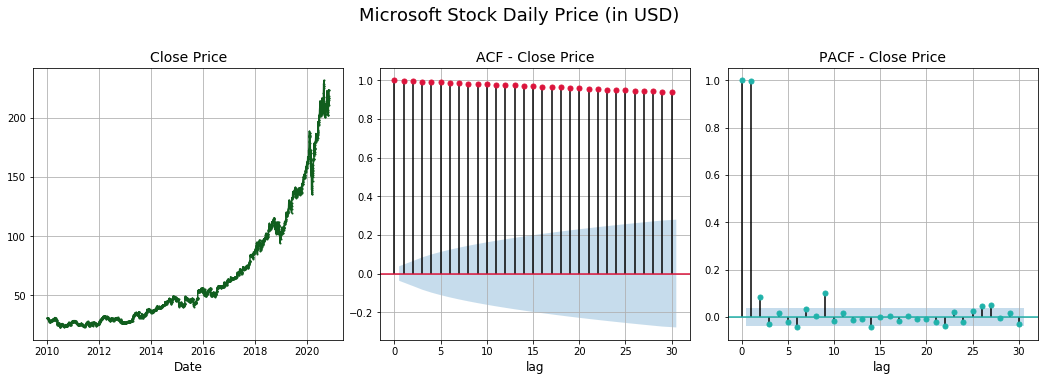

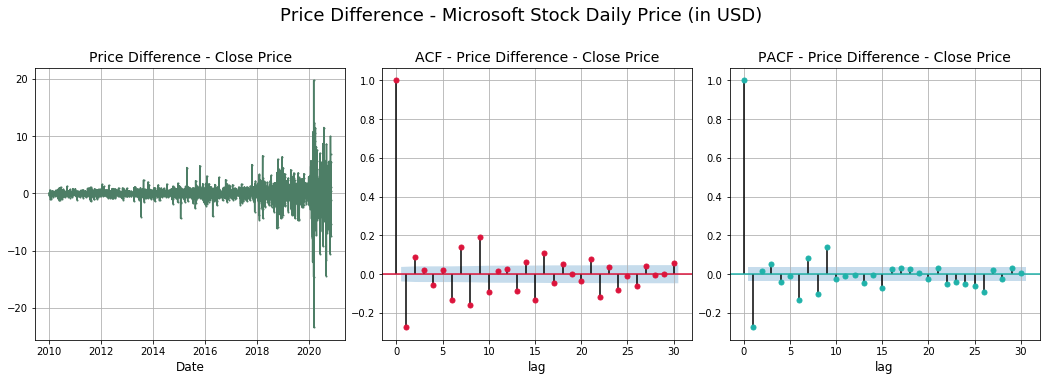

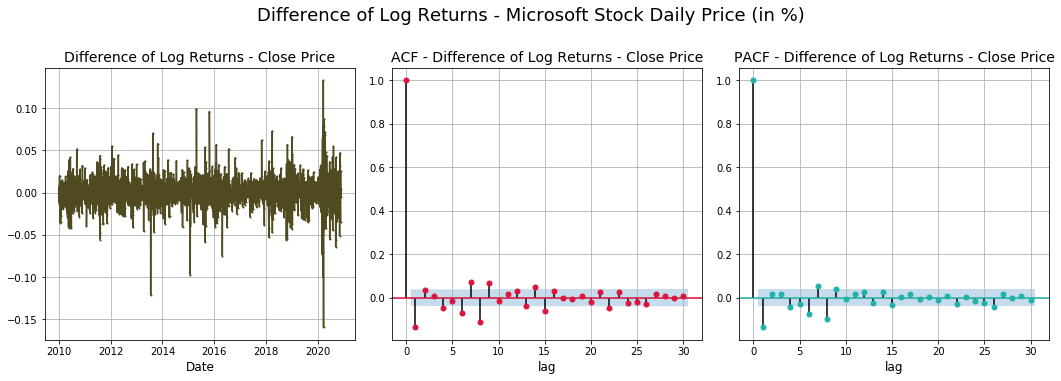

In [7]:
# Display Summary Statistics, Price Charts and ACF & PACF Plots for Price, Price Difference and Log Returns
for security in dfs_price:
    print("\n********************************* Processing", security, "*********************************")

    df = dfs_price[security]
    df_diff = dfs_price_diff[security]
    df_diff_log_returns = dfs_price_diff_log_return[security]
            
    describe_and_peek(df, security)

    # Price
    display_price_acf_pacf(df[['Close']], security, "", "USD")

    # First Order Difference of Price
    display_price_acf_pacf(df_diff[['Close']], security, "Price Difference - ", "USD")

    # First Order Difference of Daily Logarithmic Return
    display_price_acf_pacf(df_diff_log_returns[['Close']], security, "Difference of Log Returns - ", "%")

# Price Prediction using LSTM Models

## Common Functions for all the Models

In [8]:
# Given history displays Loss and RMSE curves
def plot_loss_and_rmse(history, title_prefix):
    # Extract loss and accuracy
    loss = history.history['loss']
    rmse = history.history['rmse']

    val_loss = history.history['val_loss']
    val_rmse = history.history['val_rmse']

    epochs = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 8))
    plt.suptitle(title_prefix + "Loss and RMSE", fontsize=18)

    ax[0].plot(epochs, loss, '-o', label='Training Loss')
    ax[0].plot(epochs, val_loss, '-o', color='r', label='Validation Loss')
    ax[0].grid(color='black', which='major', linestyle='dashed')
    ax[0].set_title('Training and Validation Loss', fontsize=18)
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=12)

    ax[1].plot(epochs, rmse, '-o', label='Training RMSE')
    ax[1].plot(epochs, val_rmse, '-o', color='r', label='Validation RMSE')
    ax[1].grid(color='black', which='major', linestyle='dashed')
    ax[1].set_title('Training and Validation RMSE', fontsize=18)
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('RMSE', fontsize=15)
    ax[1].legend(fontsize=12)

    plt.show();
    
# Displays Actual and Predicted prices for given dates
def plot_actual_vs_predicted(dates, actual, predictions, title_prefix, price_type):
    plt.figure(figsize=(21, 8))
    plt.plot(dates, actual, "-o", color='b', label='Actual')
    plt.plot(dates, predictions, "-o", color='r', label='Predicted')
    plt.title(title_prefix + "Actual vs Predicted", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price (USD)", fontsize=15)
    plt.xticks(dates[::6])
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show();

In [9]:
def build_complie_train_model(train_features, train_labels, val_features, val_labels, look_ahead):
    
    # Extract Input Shape
    input_shape = (train_features.shape[1], train_features.shape[2])
    
    # Create the model
    model = Sequential()

    # Add LSTM and Dropout Layers
    model.add(CuDNNLSTM(units=150, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150))
    model.add(Dropout(0.2))

    # Add dense layers
    model.add(Dense(units = look_ahead))

    # Compile the Model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[RootMeanSquaredError(name='rmse')])

    print("Training the model ...")

    # Train the model
    history = model.fit(train_features,
                        train_labels,
                        epochs=100,
                        batch_size=32,
                        validation_data=(val_features, val_labels),
                        verbose=verbose)

    print("Training completed!\n")
    
    return model, history

### Model 1 - Univariate Model

In [10]:
def univariate_model(df, scalers, security, price_type):   
    # Compute Training, Validation and Test Set Sizes
    total_size = len(df)
    total_training_size = int(total_size * 0.95)
    training_size = total_training_size - window_size
    validation_size = int((total_size - total_training_size)*0.8)
    test_size = total_size - total_training_size - validation_size

    # Print Training, Validation and Test Set Sizes
    print("Univariate Model: Total Size:", total_size,
          "Training Size:", training_size, "Validation Size:", validation_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 1
    title_prefix = security + " " + price_type + " Price - Univariate Model - "

    # Extract price and scaler for the price type
    price = df[[price_type]].values
    scaler = scalers[price_type]

    # Extract datetime for the test data from the dataframe index
    dates = df.tail(test_size).index.format()

    # Create Training, Validation and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    val_features = []
    val_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price)):
        if i < window_size + training_size:
            train_features.append(price[i-window_size:i, 0])
            train_labels.append(price[i, 0])
        elif i < (window_size + training_size + validation_size):
            val_features.append(price[i-window_size:i, 0])
            val_labels.append(price[i, 0])
        else:
            test_features.append(price[i-window_size:i, 0])
            test_labels.append(price[i, 0])
    
    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    val_features, val_labels = np.array(val_features), np.array(val_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Reshape Training, Validation and Test Feature Sets to fit LSTM input shape
    train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
    val_features = np.reshape(val_features, (val_features.shape[0], val_features.shape[1], 1))
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    
    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, val_features, val_labels, look_ahead)

    # Save the model
    model.save("lstm_univariate_" + security + '.h5', save_format='tf')
    
    # Display loss and RMSE curves
    plot_loss_and_rmse(history, title_prefix)
    
    # Use the model to predict for the test data
    predictions = model.predict(test_features)

    # Convert the predicted values to origianl scale
    predictions = scaler.inverse_transform(predictions)

    # Convert actual values to origianl scale
    actual = scaler.inverse_transform(test_labels.reshape(-1, 1))

    return "Univariate", dates, actual, predictions, mean_squared_error(actual, predictions)

### Model 2 - Univariate Multiday Look ahead Model

In [11]:
def univariate_multiday_look_ahead_model(df, scalers, security, price_type):    
    # Compute Training, Validation and Test Set Sizes
    total_size = len(df)
    total_training_size = int(total_size * 0.95)
    training_size = total_training_size - window_size
    validation_size = int((total_size - total_training_size)*0.8)
    test_size = total_size - total_training_size - validation_size

    # Print Training, Validation and Test Set Sizes
    print("Univariate MultiDay Look ahead Model: Total Size:", total_size,
          "Training Size:", training_size, "Validation Size:", validation_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 3
    title_prefix = security + " " + price_type + " Price - Univariate Multiday Look ahead Model - "

    # Extract price and scaler for the price type
    price = df[[price_type]].values
    scaler = scalers[price_type]
    
    # Extract datetime for the test data from the dataframe index
    all_dates = df.tail(test_size).index.format()

    # Create Training, Validation and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    val_features = []
    val_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price) - look_ahead + 1):  
        if i < window_size + training_size:
            train_features.append(price[i-window_size:i, 0])
            train_labels.append(price[i:i+look_ahead, 0])
        elif i < (window_size + training_size + validation_size):
            val_features.append(price[i-window_size:i, 0])
            val_labels.append(price[i:i+look_ahead, 0])
        else:
            test_features.append(price[i-window_size:i, 0])
            test_labels.append(price[i:i+look_ahead, 0])
    
    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    val_features, val_labels = np.array(val_features), np.array(val_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Reshape data to fit LSTM input shape
    train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
    val_features = np.reshape(val_features, (val_features.shape[0], val_features.shape[1], 1))
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    
    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, val_features, val_labels, look_ahead)

    # Save the model
    model.save("lstm_univariate_multiday_look_ahead_" + security + '.h5', save_format='tf')
    
    # Display loss and RMSE curves
    plot_loss_and_rmse(history, title_prefix)
    
    # Use the model to predict for the test data
    predictions = model.predict(test_features)

    # Convert the predicted values to origianl scale
    predictions = scaler.inverse_transform(predictions)

    # Convert actual values to origianl scale
    actual = scaler.inverse_transform(test_labels)    
   
    model_names = np.empty(look_ahead, dtype=object)
    dates = np.empty((test_size-look_ahead+1, look_ahead), dtype=object)
    mse = np.empty(look_ahead)

    for i in range(look_ahead):
        model_names[i] = "Univariate-Look ahead-" + str(i+1)        
        dates[:, i] = np.array(all_dates[i:i+test_size-look_ahead+1])
        mse[i] = mean_squared_error(actual[:, i], predictions[:, i])
    
    return model_names, dates, actual, predictions, mse

### Model 3 - Multivariate Model

In [12]:
def multivariate_model(df, scalers, security, price_type):
    # Compute Training, Validation and Test Set Sizes
    total_size = len(df)
    total_training_size = int(total_size * 0.95)
    training_size = total_training_size - window_size
    validation_size = int((total_size - total_training_size)*0.8)
    test_size = total_size - total_training_size - validation_size

    # Print Training, Validation and Test Set Sizes
    print("Multivariate Model: Total Size:", total_size,
          "Training Size:", training_size, "Validation Size:", validation_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 1
    title_prefix = security + " " + price_type + " Price - Multivariate Model - "

    # Extract price and scaler for the price type
    price_all = df.values
    price = df[[price_type]].values
    scaler = scalers[price_type]

    # Extract datetime for the test data from the dataframe index
    dates = df.tail(test_size).index.format()

    # Create Training, Validation and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    val_features = []
    val_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price)):
        if i < window_size + training_size:
            train_features.append(price_all[i-window_size:i, :])
            train_labels.append(price[i, 0])
        elif i < (window_size + training_size + validation_size):
            val_features.append(price_all[i-window_size:i, :])
            val_labels.append(price[i, 0])
        else:
            test_features.append(price_all[i-window_size:i, :])
            test_labels.append(price[i, 0])

    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    val_features, val_labels = np.array(val_features), np.array(val_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, val_features, val_labels, look_ahead)

    # Save the model
    model.save("lstm_multivariate_" + security + '.h5', save_format='tf')
    
    # Display loss and rmse curves
    plot_loss_and_rmse(history, title_prefix)
    
    # Use the model to predict for the test data
    predictions = model.predict(test_features)

    # Convert the predicted values to origianl scale
    predictions = scaler.inverse_transform(predictions)

    # Convert actual values to origianl scale
    actual = scaler.inverse_transform(test_labels.reshape(-1, 1))

    return "Multivariate", dates, actual, predictions, mean_squared_error(actual, predictions)

In [13]:
# Number of past values to be used for prediction
window_size = 60
# Price type to predict
price_type = "Close"


*************************************** Processing Apple Stock **************************************

Univariate Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



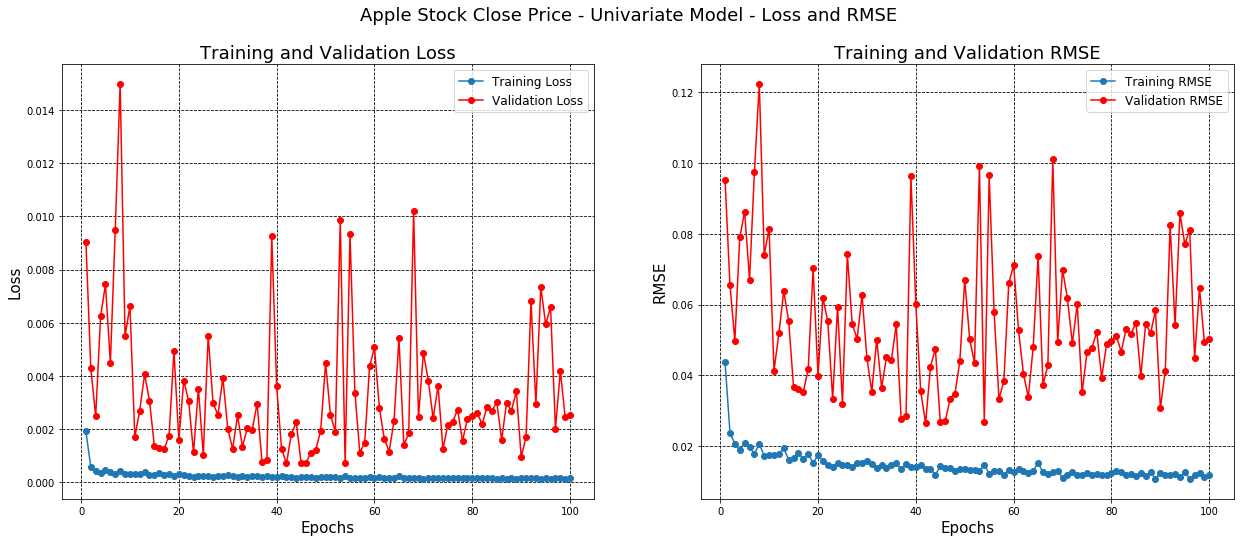

Univariate MultiDay Look ahead Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



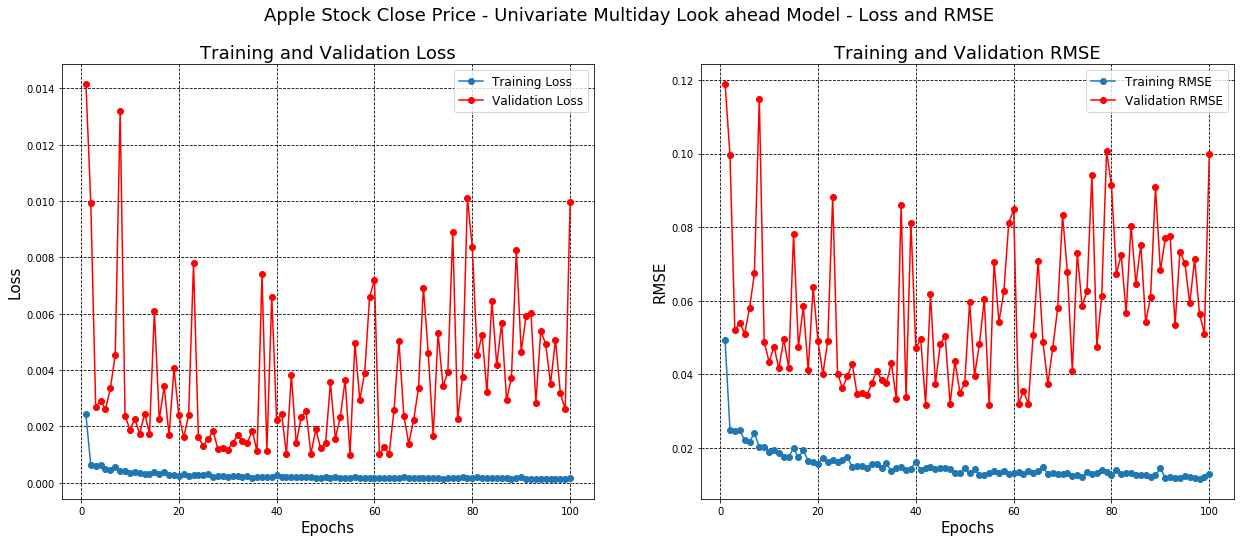

Multivariate Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



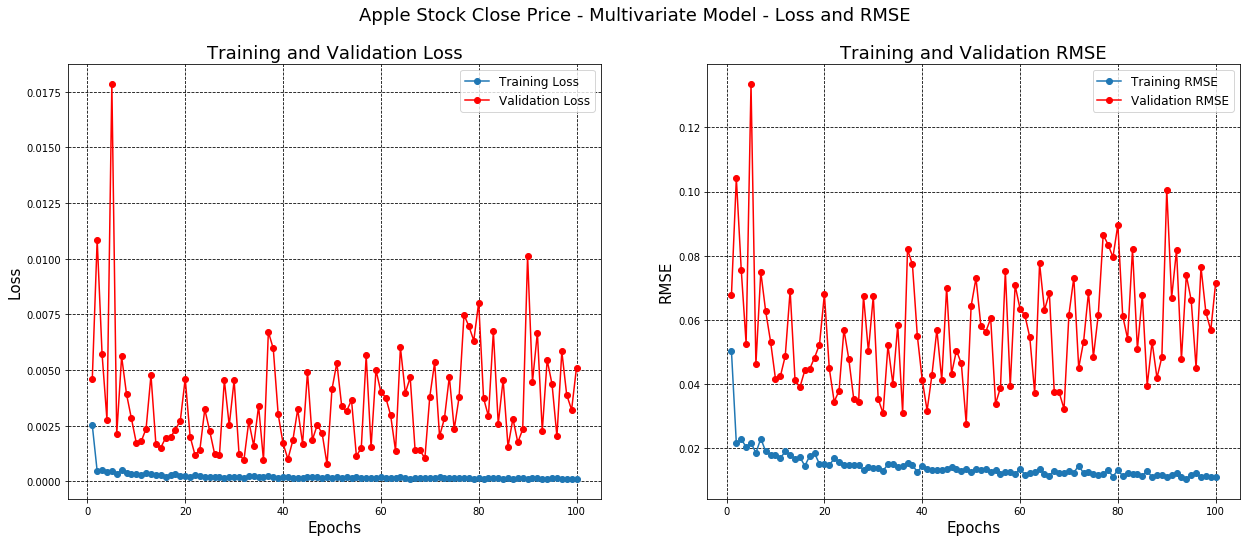


*************************************** Processing Microsoft Stock **************************************

Univariate Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



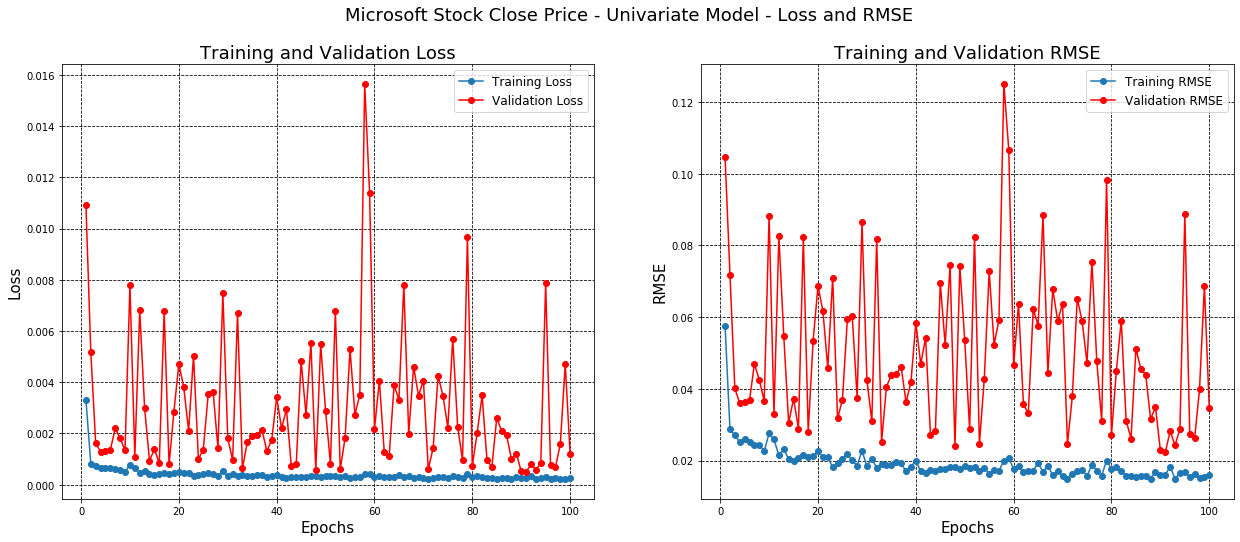

Univariate MultiDay Look ahead Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



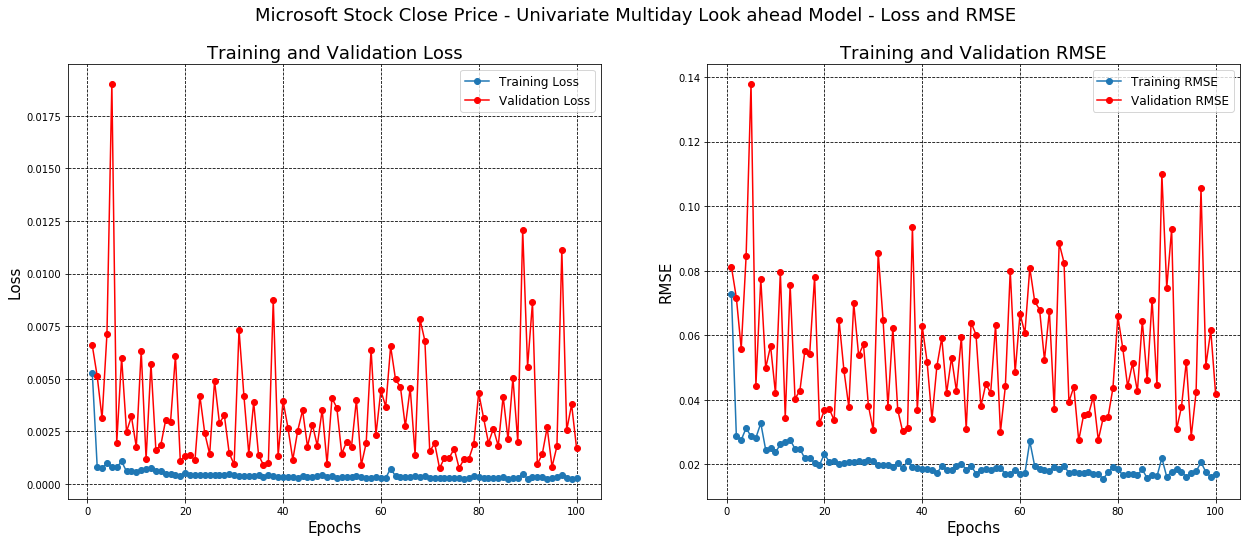

Multivariate Model: Total Size: 2737 Training Size: 2540 Validation Size: 109 Test Size: 28
Training the model ...
Training completed!



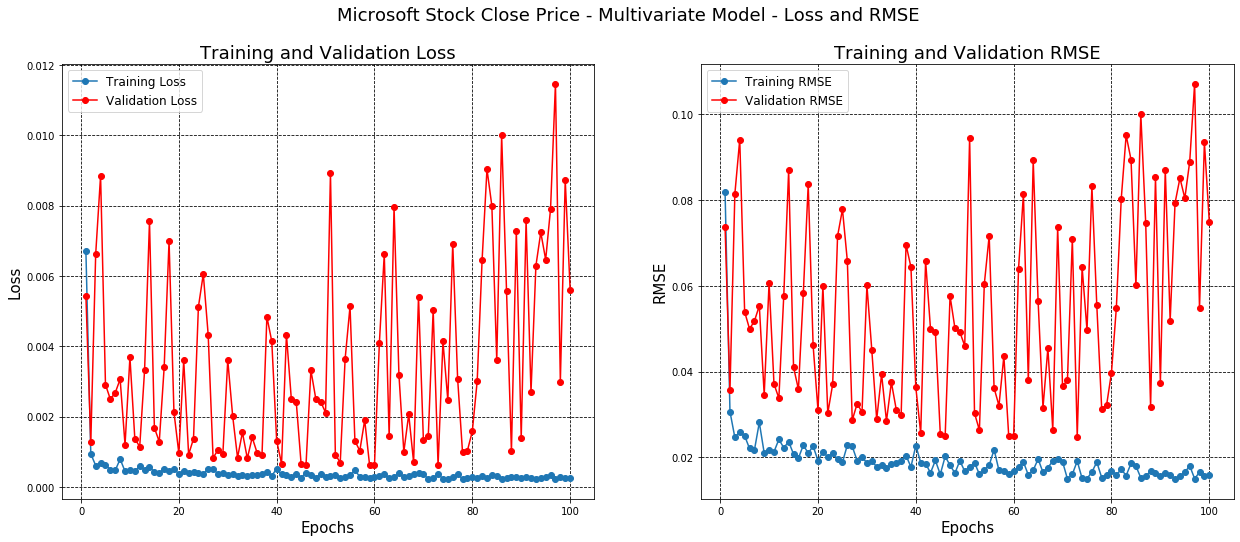

In [14]:
# Build and Predict Using all LSTM Models
results = {}
for security in dfs_price_scaled:
    print("\n*************************************** Processing", security, "**************************************\n")
    security_results = {}

    price = dfs_price_scaled[security]
    scaler = scalers[security]

    model, dates, actual, predictions, mse = univariate_model(price, scaler, security, price_type)
    security_results[model] = dates, actual, predictions, mse

    model, dates, actual, predictions, mse  = univariate_multiday_look_ahead_model(price, scaler, security, price_type)
    for i in range(len(model)):
        security_results[model[i]] = dates[:, i], actual[:, i], predictions[:, i], mse[i]

    model, dates, actual, predictions, mse  = multivariate_model(price, scaler, security, price_type)
    security_results[model] = dates, actual, predictions, mse

    results[security] = security_results

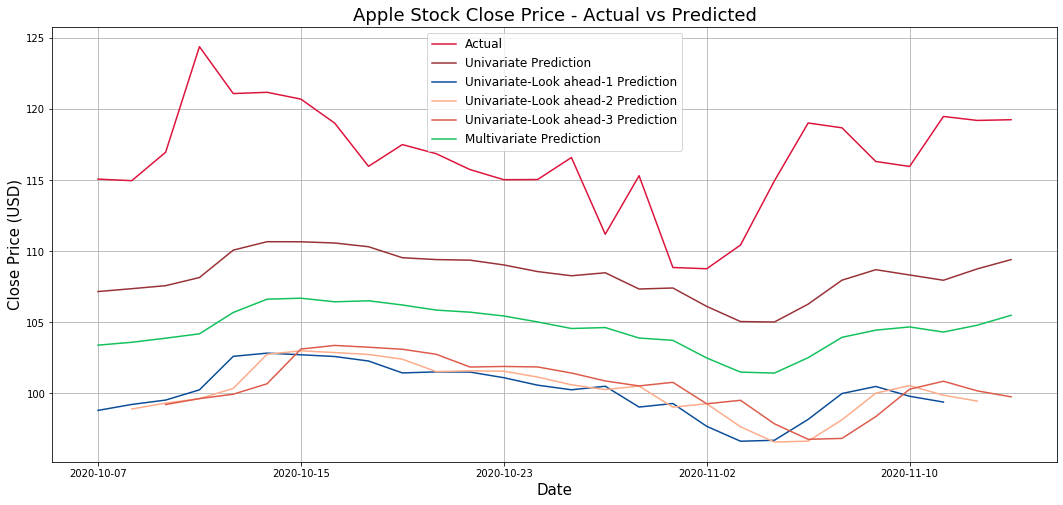

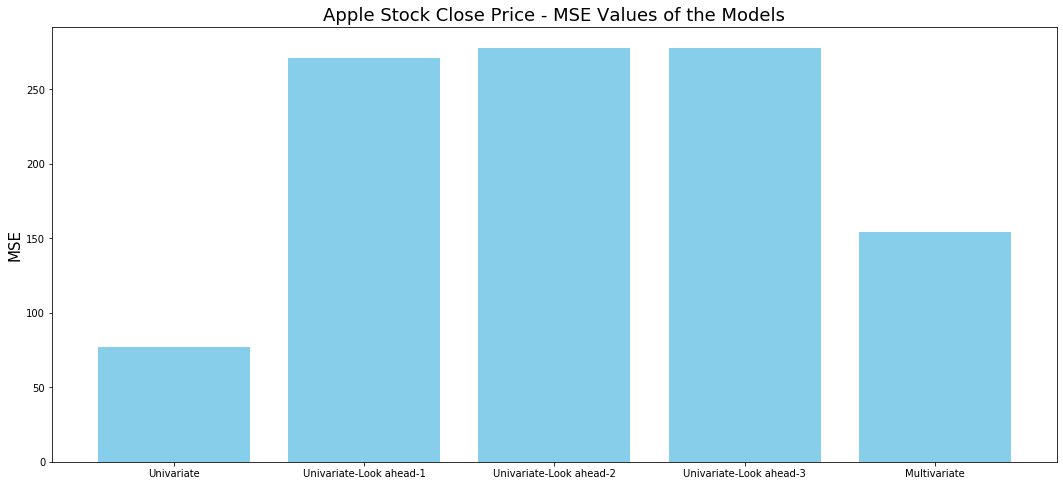

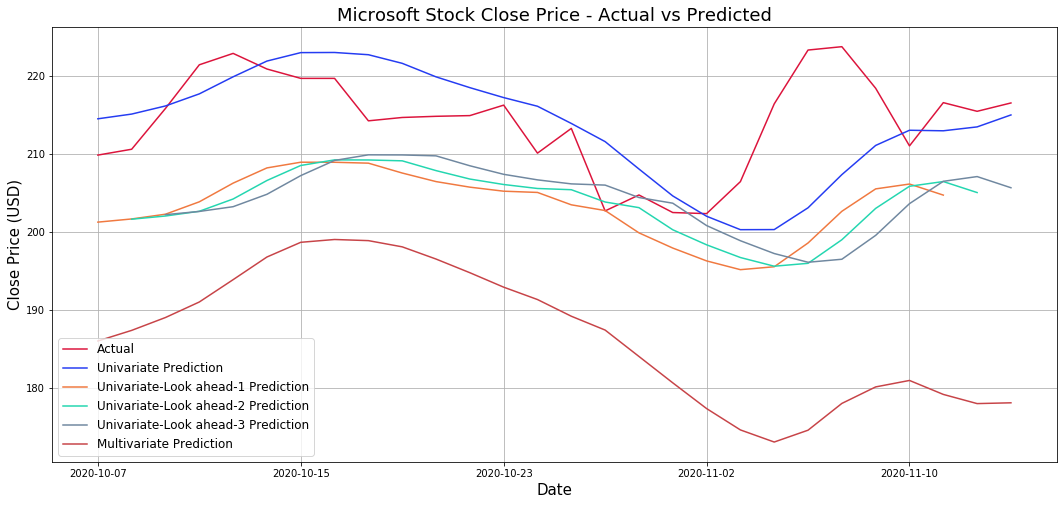

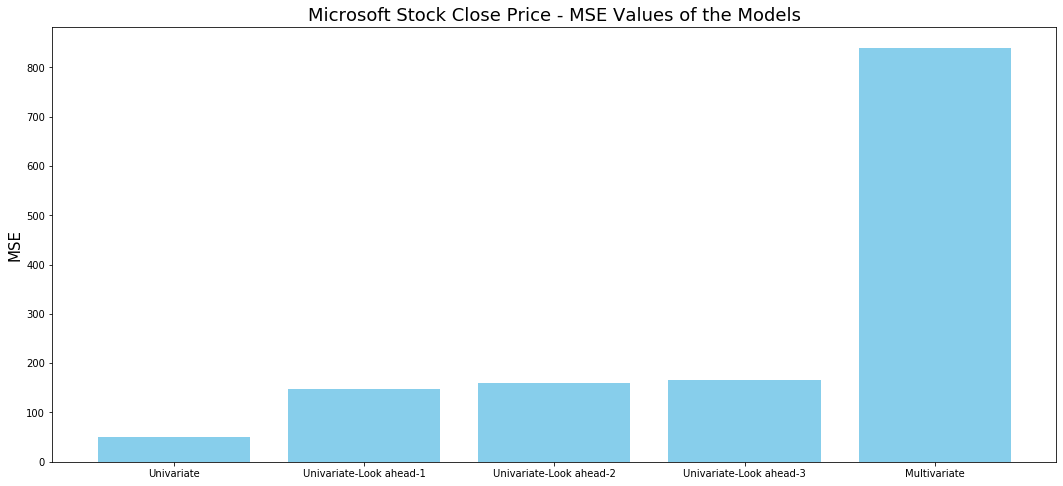

In [17]:
for security, security_results in results.items():
    model_list = []
    mse_list = []
    
    plt.figure(figsize=(18, 8))
    for model, model_results in security_results.items():
        dates, actual, predictions, mse = model_results
        model_list.append(model)
        mse_list.append(mse)
        
        if model == 'Univariate':
            plt.plot(dates, actual, "-", color='crimson', label='Actual')
        plt.plot(dates, predictions, "-", color=np.random.rand(3,), label=model + ' Prediction')        

    plt.title(security + " " + price_type + " Price - Actual vs Predicted", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price (USD)", fontsize=15)
    plt.xticks(dates[::6])    
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(18, 8))
    plt.bar(model_list, mse_list, color='skyblue')  
    plt.title(security + " " + price_type + " Price - MSE Values of the Models", fontsize=18)
    plt.ylabel("MSE", fontsize=15)
    plt.show();